# Cross Terrain Mobility
In this notebook we will demonstrate terrain detection using Sentinel-2 L2A SLC classification. 

You can find more information regarding this data on the copernicus website https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2.

We will use Sentinel-2 L2A data and the WMS API to search for and download images. We will start by downloading and displaying a true color image to have a visual reprensetation of our area of interest. Then visualize the classification and simulate a route. And finally analysing the different types of terrain that we would encounter.


## Import libraries and intitialize all parameters

In [1]:
from mundilib import MundiCatalogue
from utils import height2width
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Init wms
c = MundiCatalogue()
wms = c.get_collection("Sentinel2").mundi_wms('L2A')

Define scl class legend. This will be used later to display the legend and interpret the terrain data.

In [2]:
legend_data = [[0, [0, 0, 0], 'No Data'],
              [1, [1, 0, 0.016], 'Saturated / Defective'],
              [2, [0.525, 0.525, 0.525], 'Dark Area'],
              [3, [0.467, 0.298, 0.043], 'Cloud shadows'],
              [4, [0.063, 0.827, 0.176], 'Vegetation'],
              [5, [1, 1, 0.325], 'Bare soil'],
              [6, [0, 0, 1], 'Water'],
              [7, [0.506, 0.506, 0.506], 'Clouds low probability / Unclassified'],
              [8, [0.753, 0.753, 0.753], 'Clouds medium probability'],
              [9, [0.949, 0.949, 0.949], 'Clouds high probability'],
              [10, [0.733, 0.773, 0.925], 'Cirrus'],
              [11, [0.325, 1, 0.980], 'Snow / Ice']]

legend_dict = dict()
for values in legend_data:
    legend_dict[values[0]] = values[2]


Define WMS parameters. We define here the bounding box, dates and images size that will be used for this first use case.

In [3]:
_projection_ = 'EPSG:4326'
_bbox_       = (1.3691896336775358, 43.45076739750934, 1.550892291377437, 43.52969044787278)
_time_       = '2023-02-06/2023-02-10'
_height_     = 512
_width_      = height2width(_bbox_, _height_)

## First use case: river crossings

### Getting a True Color image to inspect visualy the aoi

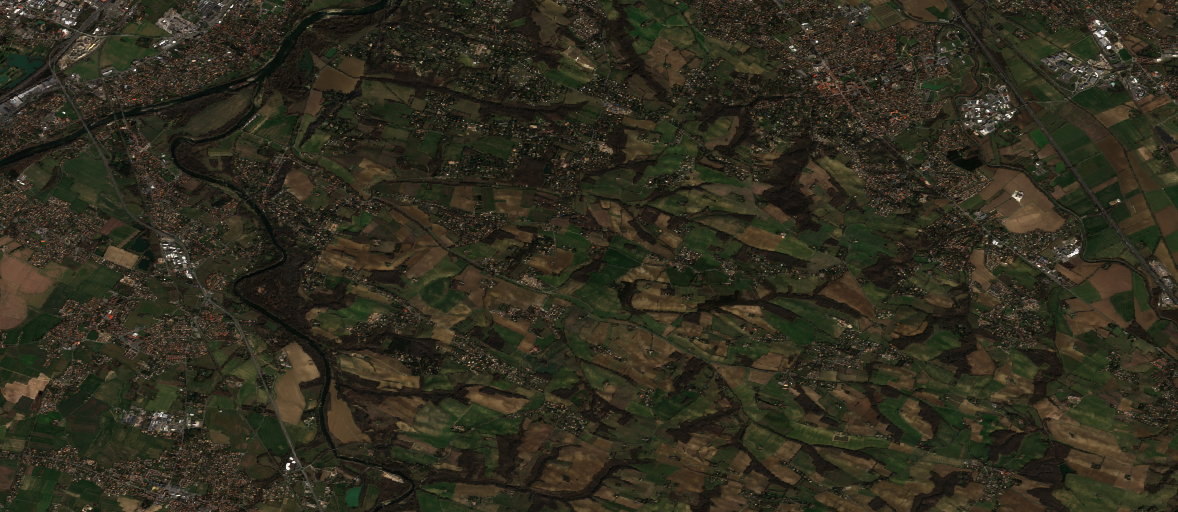

In [4]:
img_tc = wms.getmap(layers=['TRUE_COLOR'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

display(Image.open(img_tc))

### Request SLC mask 

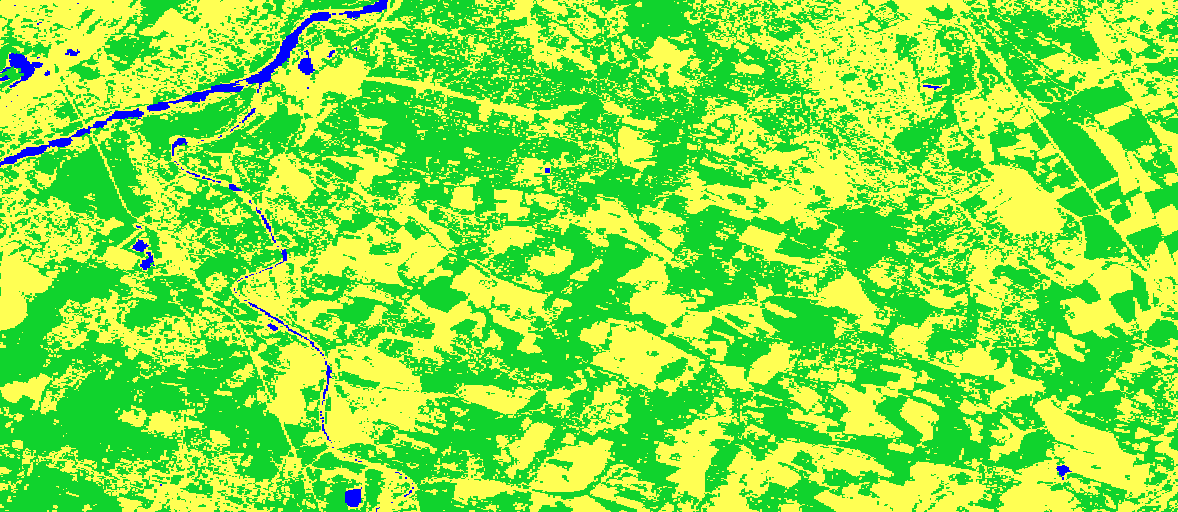

In [5]:
img_scl = wms.getmap(layers=['SCL'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

display(Image.open(img_scl))

### Display SLC mask with its legend

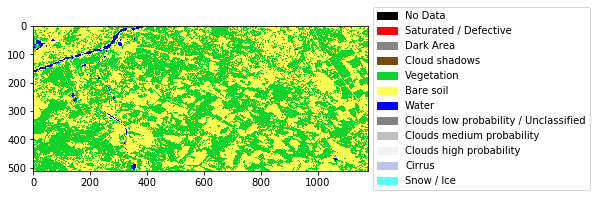

In [6]:
scl_array = np.asarray(Image.open(img_scl))

handles = [
    Rectangle((0,0),1,1, color = c) for k,c,n in legend_data
]
labels = [n for k,c,n in legend_data]

plt.imshow(scl_array)
plt.legend(handles,labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Now lets try to simulate a route 

We will use the layer SCL_GRAYSCALE to get the raw scl value.
Then define a route and display it by replacing the pixel values to red.

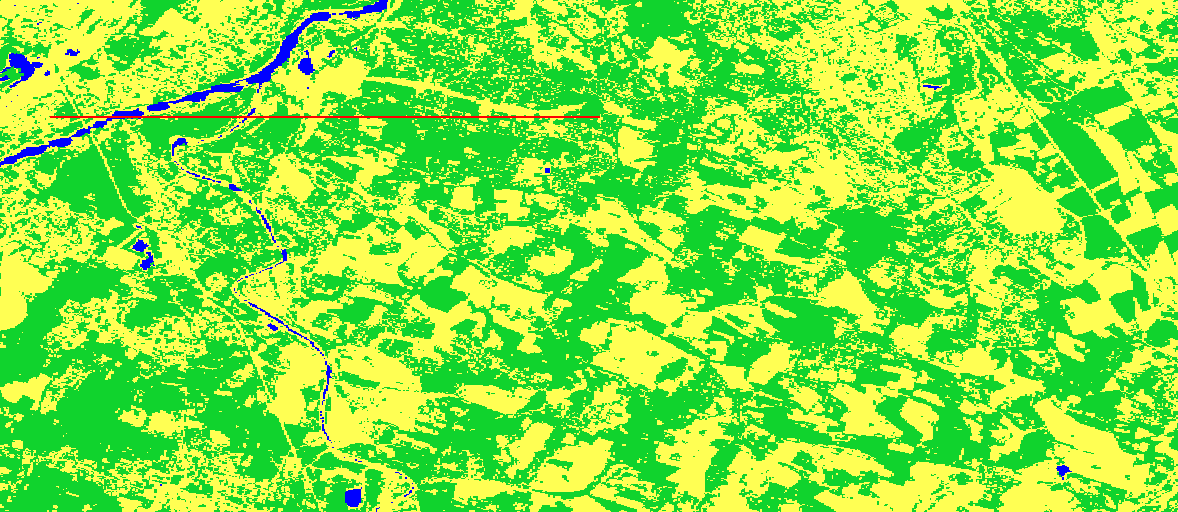

In [7]:
img_scl_raw = wms.getmap(layers=['SCL_GRAYSCALE'],
                     srs=_projection_,
                     bbox=_bbox_,
                     size=(_width_, _height_),
                     format='image/tiff',
                     time=_time_,
                     showlogo=False,
                     transparent=False)

scl_raw_array = np.asarray(Image.open(img_scl_raw))
scl_array = np.asarray(Image.open(img_scl))

mobility = scl_raw_array[120, 50:600]
mobility_visualization = scl_array[120, 50:600]
mobility = list(mobility/23) # Store terrain data as a list for better usability latter

writable_array = scl_array.copy()
writable_array[116:118, 50:600][:] = [255, 0, 0]

display(Image.fromarray(writable_array))


### Now lets analyse the data

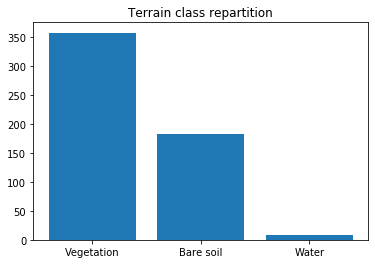

In [8]:
# Getting the list of unique values 
x = [] # Init x
y = [] # Init y

for classes in set(mobility):
    y.append(mobility.count(classes))
    x.append(legend_dict[classes])

plt.bar(x, y)
plt.title("Terrain class repartition")
plt.show()



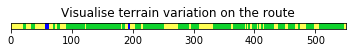

In [9]:
mobility_shape = list(np.asarray(mobility_visualization).shape)
one = np.ones((10, mobility_shape[0], mobility_shape[1]), dtype=int)
mobility_visualize = one*mobility_visualization # Enlarging a bit the pixel line for visalisation purposes

plt.imshow(mobility_visualize)
plt.yticks([]) 
plt.title('Visualise terrain variation on the route')
plt.show()

## Second use case: Snowy region

### Doing the same thing again with a different AOI

Displaying tre color image and then visualizing the route over the classification.

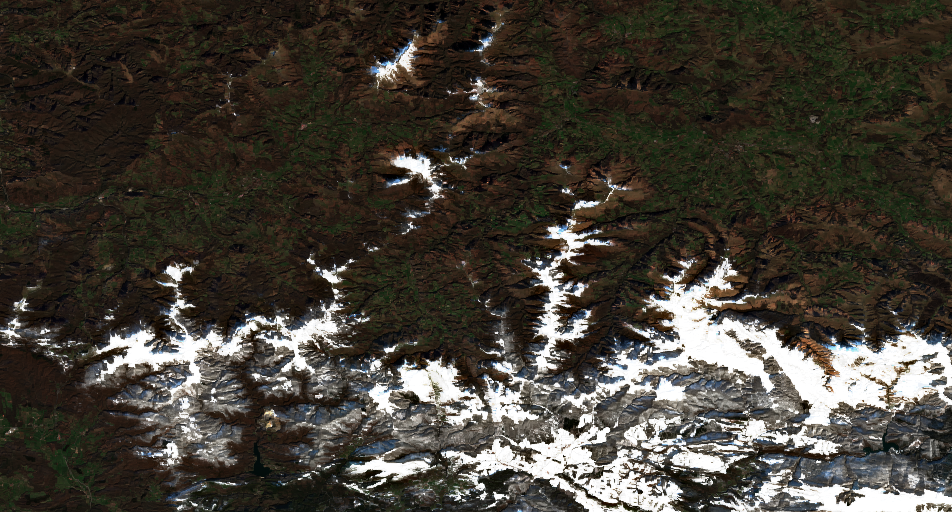

In [10]:
_projection_ = 'EPSG:4326'
_bbox_       = (-1.6688273485070795, 42.951506610423564, -1.1068599800720165, 43.253494261664684)
_time_       = '2023-02-04/2023-02-30'
_height_     = 512
_width_      = height2width(_bbox_, _height_)

img_tc = wms.getmap(layers=['TRUE_COLOR'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

display(Image.open(img_tc))

In [11]:
img_scl = wms.getmap(layers=['SCL'],
                 srs=_projection_,
                 bbox=_bbox_,
                 size=(_width_, _height_),
                 format='image/png',
                 time=_time_,
                 showlogo=False,
                 transparent=False)

# display(Image.open(img_scl))

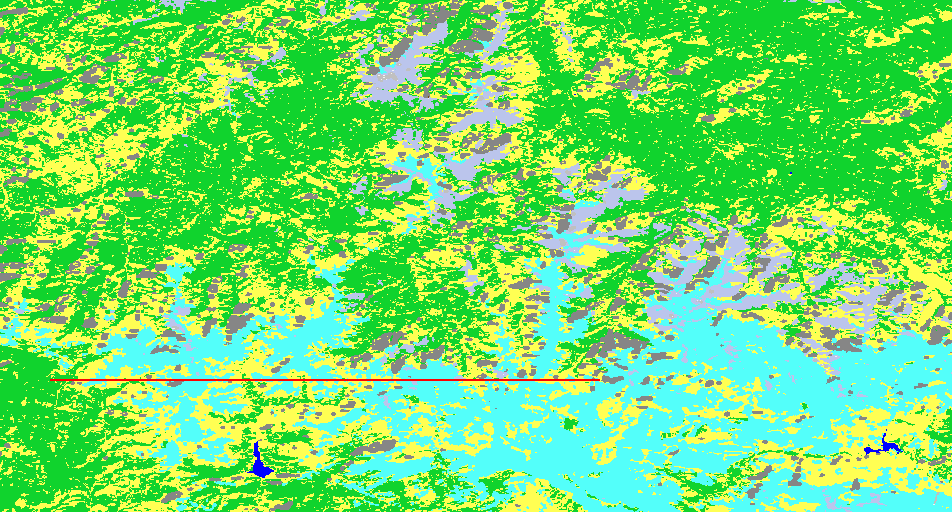

In [12]:
img_scl_raw = wms.getmap(layers=['SCL_GRAYSCALE'],
                     srs=_projection_,
                     bbox=_bbox_,
                     size=(_width_, _height_),
                     format='image/tiff',
                     time=_time_,
                     showlogo=False,
                     transparent=False)

scl_raw_array = np.asarray(Image.open(img_scl_raw))
scl_array = np.asarray(Image.open(img_scl))

mobility = scl_raw_array[380, 50:600]
mobility_visualization = scl_array[380, 50:600]
mobility = list(mobility/23) # Store terrain data as a list for better usability latter

writable_array = scl_array.copy()
writable_array[379:381, 50:600][:] = [255, 0, 0]

display(Image.fromarray(writable_array))

### Now lets analyse the data

There are a few more classes due to teh presence of snow and shadow on the ground caused by the mountain tops.

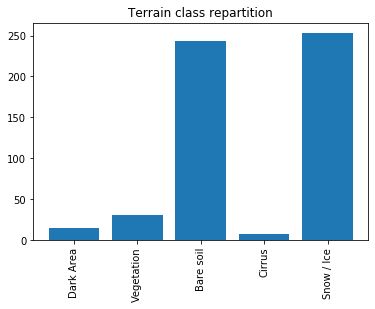

In [13]:
# Getting the list of unique values 
x = [] # Init x
y = [] # Init y

for classes in set(mobility):
    y.append(mobility.count(classes))
    x.append(legend_dict[classes])

plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("Terrain class repartition")
plt.show()


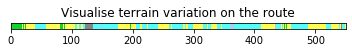

In [14]:
mobility_shape = list(np.asarray(mobility_visualization).shape)
one = np.ones((10, mobility_shape[0], mobility_shape[1]), dtype=int)
mobility_visualize = one*mobility_visualization # Enlarging a bit the pixel line for visalisation purposes

plt.imshow(mobility_visualize)
plt.yticks([]) 
plt.title('Visualise terrain variation on the route')
plt.show()